# Adversarial Patch Defence


## Imports & Globals

In [124]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F
os.chdir('/home/jovyan/DL_Project02')
!pwd

/home/jovyan/DL_Project02


## Load Dataset and Calssification model

In this section all the necessary parameters and models(ResNet101) are defined for the defence process. Also the dataset are loaded and divided into two different pools, train and datasets.

In [125]:

DATA_ROOT = "./data_gtsrb"
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_set = datasets.GTSRB(
    DATA_ROOT, 
    split="train", 
    download=True, 
    transform=tfms
)

test_set  = datasets.GTSRB(
    DATA_ROOT, 
    split="test",  
    download=True, 
    transform=tfms
)

indices = random.sample(range(len(train_set)), 600)
small_train_set = Subset(train_set, indices)

indices = random.sample(range(len(test_set)), 600)
small_test_set = Subset(test_set, indices)

test_loader = DataLoader(
    small_test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)


cuda


In [126]:

CKPT_PATH = "./ResNet_Models/resnet101_gtsrb_best.pt"
NUM_CLASSES = 43
weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.resnet101(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# Robust: checkpoint might be {"model_state": ...} or directly a state_dict
state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state_dict)

model.to(DEVICE).eval();

## Patch Segmentation Dataset

To train the segmentation algorithm first a deticated dataset must be constructed with patched images with adversarial patches and their binary mask which indicates the patch position. Each sample contains a patched image and a binary mask. The patched is applied to a random position with random size between a scaling factor of 0.5 to 1.5.

In [127]:
# Load patch from the Patches Directory.
patch = torch.load(f"./Patches/Target_9_patch_SRT9351_MR9502.pt")
patch_size = patch.shape[2]
print("patch size = ",patch_size)

patch size =  40


In [128]:

class PatchSegmentationDataset(Dataset):
    def __init__(
        self,
        base_dataset,
        patch,
        base_patch_size=40,
        scale_range=(0.5, 1.5)   # min max scale factors
    ):
        self.base_dataset = base_dataset
        self.patch = patch.detach().cpu()   # safe
        self.base_patch_size = base_patch_size
        self.scale_range = scale_range

    def __len__(self):
        return len(self.base_dataset)

    def resize_patch(self, scale):
        new_size = int(self.base_patch_size * scale)
        new_size = max(8, new_size)  # safety

        patch = self.patch.unsqueeze(0)  # (1,C,H,W)
        patch = F.interpolate(
            patch,
            size=(new_size, new_size),
            mode="bilinear",
            align_corners=False
        )
        return patch.squeeze(0), new_size

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        img = img.clone()

        _, H, W = img.shape

        # ---- random scale ----
        scale = random.uniform(*self.scale_range)
        patch_resized, patch_size = self.resize_patch(scale)

        mask = torch.zeros((1, H, W), dtype=torch.float32)

        # ---- random position ----
        x = random.randint(0, W - patch_size)
        y = random.randint(0, H - patch_size)

        # ---- apply patch ----
        img[:, y:y+patch_size, x:x+patch_size] = patch_resized
        mask[:, y:y+patch_size, x:x+patch_size] = 1.0

        return img, mask


seg_dataset = PatchSegmentationDataset(
    small_train_set, 
    patch, 
    base_patch_size=patch_size
    )
seg_loader = DataLoader(seg_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

seg_test_dataset = PatchSegmentationDataset(
    small_test_set, 
    patch, 
    base_patch_size=patch_size
)
seg_test_loader = DataLoader(seg_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


## Visualise train dataset

A sanity check to veriy the dataset are contructed correctly for the training and testing.

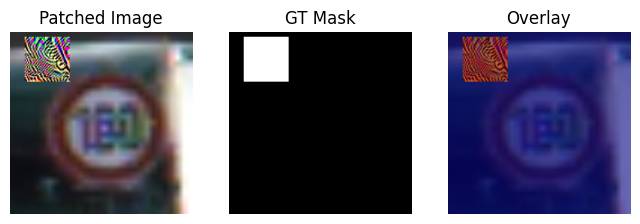

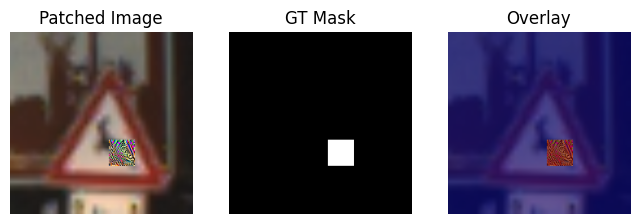

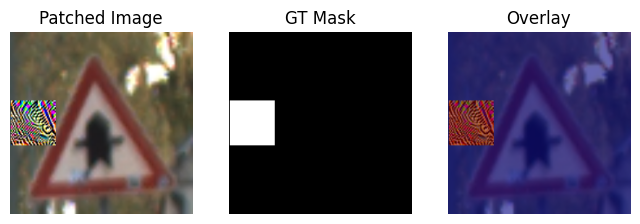

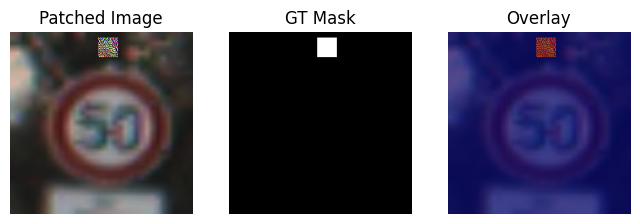

In [129]:

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img * std + mean


# get one batch
images, masks = next(iter(seg_loader))
images = images[:4]
masks = masks[:4]

for i in range(4):
    img = denormalize(images[i], imagenet_mean, imagenet_std)
    img = img.permute(1,2,0).clamp(0,1)

    mask = masks[i][0]

    plt.figure(figsize=(8,3))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Patched Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.imshow(mask, cmap="jet", alpha=0.6)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


## Define and Train the Patch Detector

This section defines the U-Net model which will be used as a segmentation model to detect and localise the patch on the image.

### Architecture Overview

#### DoubleConv Block
A basic building block that performs two consecutive convolutions:
- Conv2D (3×3, padding=1) → ReLU
- Conv2D (3×3, padding=1) → ReLU

#### UNet Structure

**Encoder (Downsampling Path):**
- `d1`: DoubleConv(3 → 64) - processes RGB input
- `d2`: DoubleConv(64 → 128) - after max pooling
- `b`: DoubleConv(128 → 256) - bottleneck after second pooling

**Decoder (Upsampling Path with Skip Connections):**
- `u1`: DoubleConv(256+128 → 128) - concatenates upsampled bottleneck with c2
- `u2`: DoubleConv(128+64 → 64) - concatenates upsampled u1 with c1

**Output Layer:**
- `out`: Conv2D(64 → 1, kernel=1) - produces single-channel segmentation map
- Sigmoid activation - outputs binary mask (0-1 range)

**Pooling:**
- MaxPool2d(2) - reduces spatial dimensions by half

In [130]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.b = DoubleConv(128, 256)
        self.u1 = DoubleConv(256 + 128, 128)
        self.u2 = DoubleConv(128 + 64, 64)
        self.out = nn.Conv2d(64, 1, 1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.pool(c1))
        b = self.b(self.pool(c2))
        u1 = self.u1(torch.cat([torch.nn.functional.interpolate(b, scale_factor=2), c2], dim=1))
        u2 = self.u2(torch.cat([torch.nn.functional.interpolate(u1, scale_factor=2), c1], dim=1))
        return torch.sigmoid(self.out(u2))


The model is trained with hyperparameters of epochs=20, learning rate=0.0001.

In [131]:
# EPOCHS = 20

# train_seg_model = UNet().cuda()
# opt = torch.optim.Adam(train_seg_model.parameters(), 1e-4)
# loss_fn = nn.BCELoss()

# for epoch in range(EPOCHS):
#     total_loss = 0.0

#     for images, masks in seg_loader:
#         images = images.to(DEVICE)
#         masks = masks.to(DEVICE)

#         preds = train_seg_model(images)
#         loss = loss_fn(preds, masks)

#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}: avg loss = {total_loss / len(seg_loader):.4f}")

# torch.save(train_seg_model.state_dict(), "./Segmentation_Models/seg_Umodel_varyPatch.pth")

## Segmentation results
This section vizuilise the binary mask results from the segmentation model and measure the accuracy of the predicted mask and the ground truth in the pixel level.

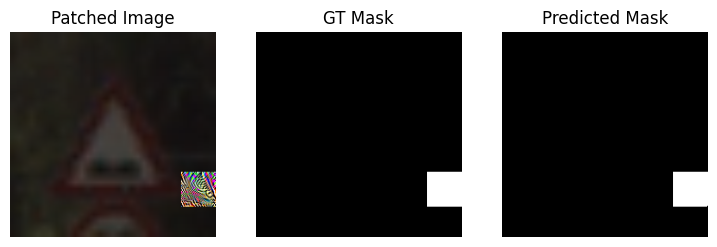

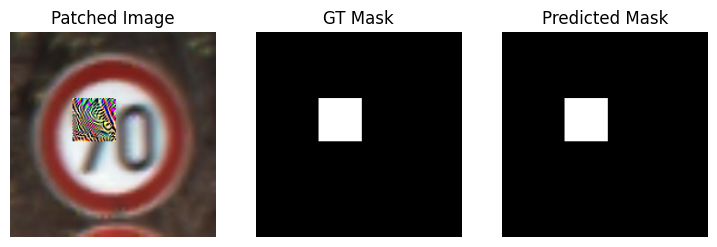

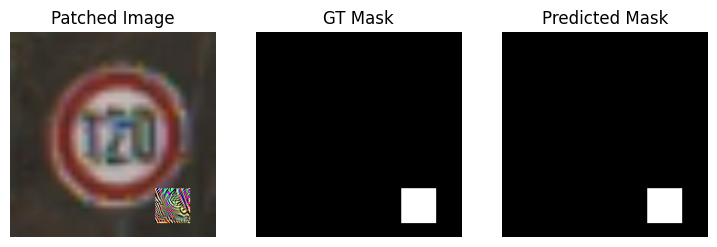

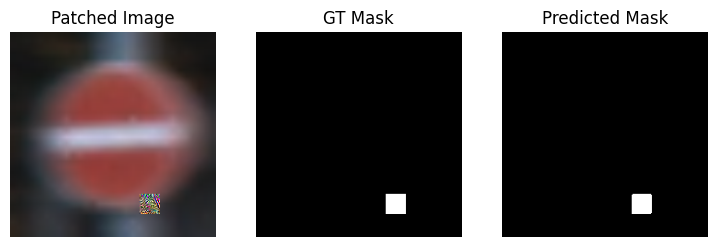

In [132]:
# binary mask presentation and comparison with the ground truth.
seg_model = UNet()   # or your exact model class
seg_model.load_state_dict(
    torch.load("./Segmentation_Models/seg_Umodel_varyPatch.pth", map_location=DEVICE)
)
seg_model = seg_model.to(DEVICE)
seg_model.eval();

with torch.no_grad():
    images, masks = next(iter(seg_test_loader))
    images = images[:4].to(DEVICE)
    masks = masks[:4]

    preds = seg_model(images).cpu()

for i in range(4):
    img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    img = img.permute(1,2,0).clamp(0,1)

    gt_mask = masks[i][0]
    pred_mask = (preds[i][0] > 0.5).float()

    plt.figure(figsize=(9,3))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Patched Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [133]:

def evaluate_segmentation(seg_model, loader, device=DEVICE, threshold=0.5, eps=1e-7):
    seg_model.eval()
    tp = fp = fn = tn = 0

    with torch.no_grad():
        for images, gt_masks in loader:
            images = images.to(device)
            gt = (gt_masks.to(device) > 0.5)        # [B,1,H,W] boolean
            preds = (seg_model(images) > threshold) # [B,1,H,W] boolean

            tp += (preds & gt).sum().item()
            fp += (preds & ~gt).sum().item()
            fn += (~preds & gt).sum().item()
            tn += (~preds & ~gt).sum().item()

    total = tp + fp + fn + tn
    pixel_acc = (tp + tn) / max(total, 1)
    iou       = tp / max(tp + fp + fn, 1)
    dice      = (2 * tp) / max(2 * tp + fp + fn, 1)
    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)

    return {
        "pixel_acc": pixel_acc,
        "IoU": iou,
        "Dice": dice,
        "precision": precision,
        "recall": recall,
    }

metrics = evaluate_segmentation(seg_model, seg_test_loader)


In [134]:
print({k: f"{v*100:.2f}%" for k, v in metrics.items()})
# ...existing code...

{'pixel_acc': '100.00%', 'IoU': '99.91%', 'Dice': '99.95%', 'precision': '99.96%', 'recall': '99.95%'}


### Patche removal
A patch removal algorithm is defined to crop out the corapted part and replace it with the mean colour of the sournded colours.

In [135]:
def remove_patch(images, masks):
    """
    images: [B,3,H,W]
    masks:  [B,1,H,W]
    """
    cleaned = images.clone()

    masks = masks.expand(-1, 3, -1, -1)

    # image-wise mean color
    mean = images.mean(dim=[2,3], keepdim=True)

    cleaned[masks > 0.5] = mean.expand_as(cleaned)[masks > 0.5]

    return cleaned


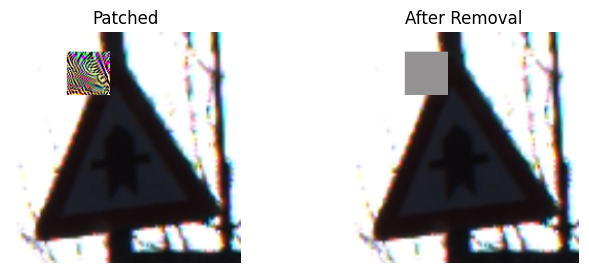

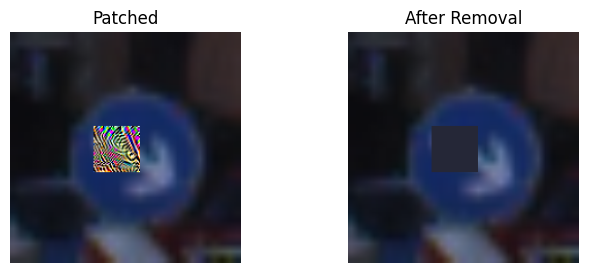

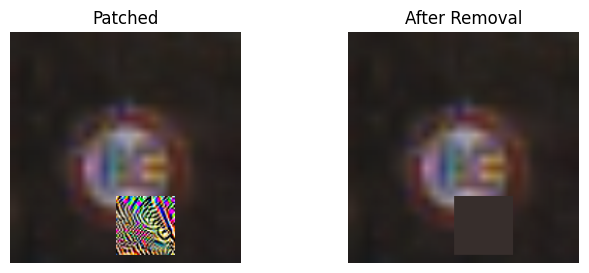

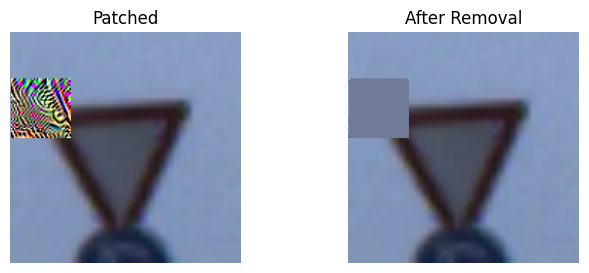

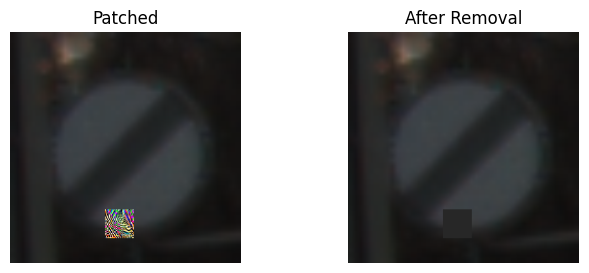

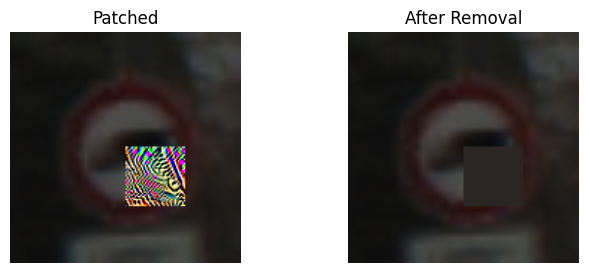

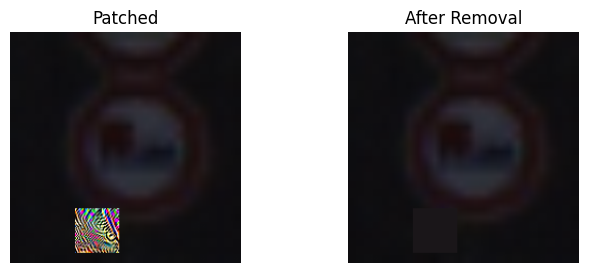

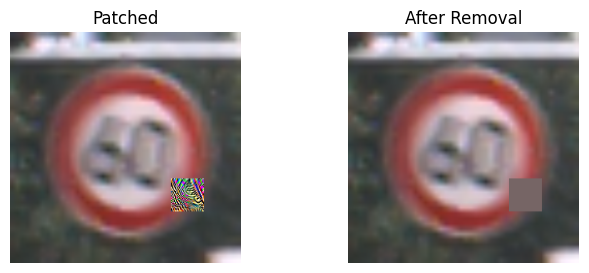

In [136]:
with torch.no_grad():
    images, _ = next(iter(seg_test_loader))
    images = images.to(DEVICE)

    #patched = apply_patch(images, patch)
    pred_mask = seg_model(images)
    cleaned = remove_patch(images, pred_mask)

for i in range(8):
    p_img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    c_img = denormalize(cleaned[i].cpu(), imagenet_mean, imagenet_std)

    p_img = p_img.permute(1,2,0).clamp(0,1)
    c_img = c_img.permute(1,2,0).clamp(0,1)

    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.imshow(p_img)
    plt.title("Patched")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(c_img)
    plt.title("After Removal")
    plt.axis("off")

    plt.show()


## Measure Accuracy of the classifier

A test dataset is built to check the accuracy of the classifier before and after the defence. Each sample contains a patched image, a patched removed image and the ground truth label. 

In [137]:
#patch = torch.load(f"./Patches/Target_9_patch_SRT9351_MR9502.pt")

def resize_patch(patch, new_size):
    if isinstance(new_size, int):
        new_size = (new_size, new_size)

    patch = patch.unsqueeze(0)  # [1,3,H,W]
    patch = F.interpolate(
        patch,
        size=new_size,
        mode="bilinear",
        align_corners=False
    )
    return patch.squeeze(0)     # [3,new_H,new_W]

def apply_patch(
    images,
    base_patch=patch,
    min_size=patch_size,
    max_size=patch_size
):
    B, C, H, W = images.shape
    patched = images.clone()

    for i in range(B):
        patch_size = random.randint(min_size, max_size)
        patch = resize_patch(base_patch, patch_size)

        x = random.randint(0, W - patch_size)
        y = random.randint(0, H - patch_size)

        patched[i, :, y:y+patch_size, x:x+patch_size] = patch

    return patched.clamp(-2.5, 2.5)



    


In [138]:
def build_defended_dataset(
    base_dataset,
    apply_patch,
    seg_model,
    device,
    batch_size=20,
    num_workers=2
):
    seg_model.eval()

    defended_images = []
    defended_labels = []
    patched_images = []

    loader = DataLoader(
        base_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            patched = apply_patch(images)
            masks = seg_model(patched)
            defended = remove_patch(patched, masks)

            defended_images.append(defended.cpu())
            defended_labels.append(labels.cpu())
            patched_images.append(patched.cpu())

    defended_images = torch.cat(defended_images)
    defended_labels = torch.cat(defended_labels)
    patched_images = torch.cat(patched_images)

    return TensorDataset(defended_images, defended_labels, patched_images)


defended_dataset = build_defended_dataset(
    test_set,            
    apply_patch,
    seg_model,
    DEVICE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
defended_loader = DataLoader(
    defended_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

Check the defended dataset if it is correct generated.

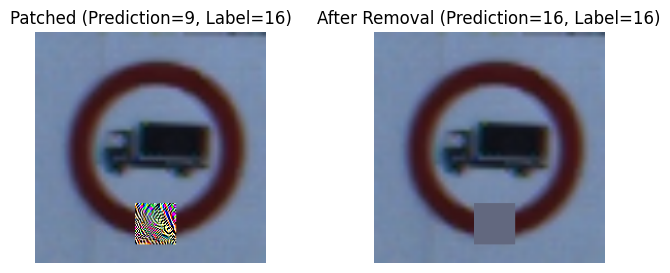

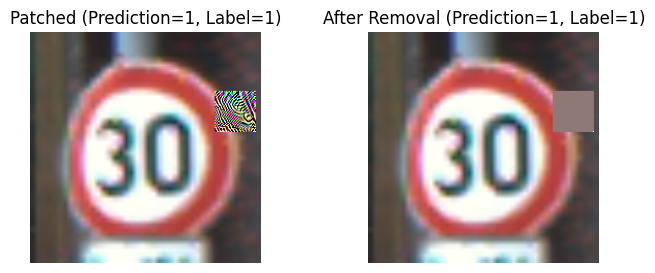

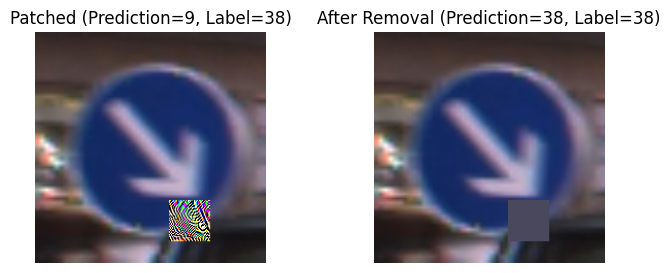

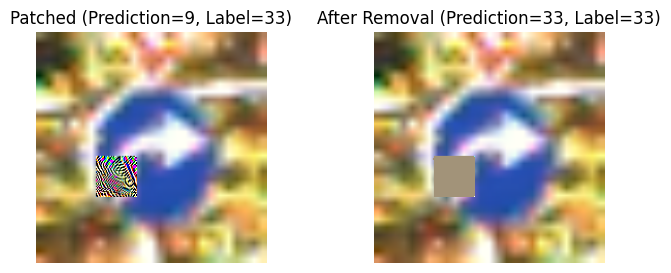

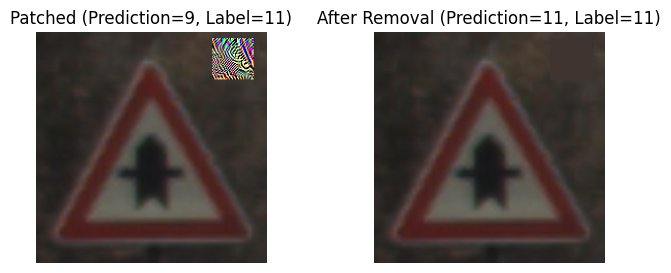

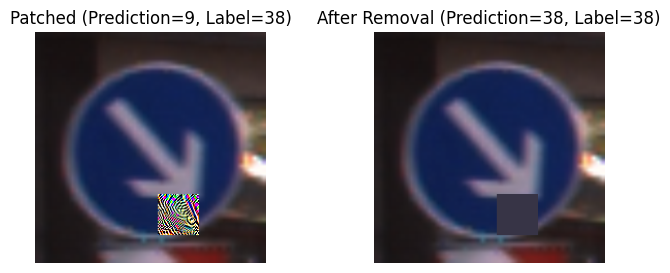

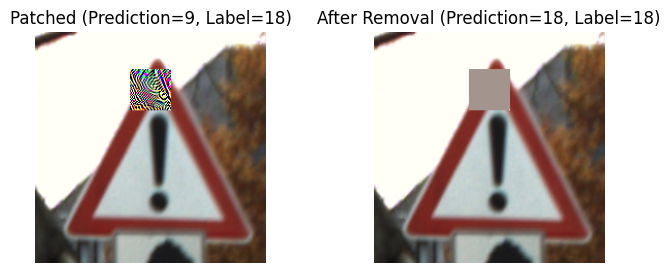

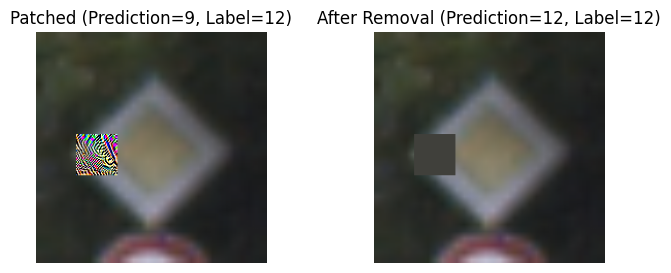

In [139]:
model.eval()
with torch.no_grad():
    defended_images, defended_labels, patched_images = next(iter(defended_loader))
    defended_images = defended_images.to(DEVICE)
    patched_images = patched_images.to(DEVICE)

    #patched = apply_patch(images, patch)
    # pred_mask = seg_model(defended_images)
    # cleaned = remove_patch(defended_images, pred_mask)

for i in range(8):
    p_img = denormalize(patched_images[i].cpu(), imagenet_mean, imagenet_std)
    c_img = denormalize(defended_images[i].cpu(), imagenet_mean, imagenet_std)
    label= defended_labels[i].item()
    p_img = p_img.permute(1,2,0).clamp(0,1)
    c_img = c_img.permute(1,2,0).clamp(0,1)

    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.imshow(p_img)
    plt.title(f"Patched (Prediction={model(patched_images[i:i+1].to(DEVICE)).argmax(dim=1).item()}, Label={label})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(c_img)
    plt.title(f"After Removal (Prediction={model(defended_images[i:i+1].to(DEVICE)).argmax(dim=1).item()}, Label={label})")
    plt.axis("off")

    plt.show()


In [140]:

def evaluate_clean(model, loader, target_class=None):
    model.eval()
    defended_correct = 0
    attacked_correct = 0
    total = 0

    with torch.no_grad():
        for defended_images, labels, patched_images in loader:
            defended_images = defended_images.to(DEVICE)
            patched_images = patched_images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Exclude target-class samples (optional)
            if target_class is not None:
                mask = labels != target_class
                if mask.sum() == 0:
                    continue
                defended_images = defended_images[mask]
                patched_images = patched_images[mask]
                labels = labels[mask]

            defended_preds = model(defended_images).argmax(dim=1)
            attacked_preds = model(patched_images).argmax(dim=1)
            defended_correct += (defended_preds == labels).sum().item()
            attacked_correct += (attacked_preds == labels).sum().item()
            total += labels.size(0)

    defended_acc = defended_correct / max(total, 1)
    attacked_acc = attacked_correct / max(total, 1)
    return defended_acc, attacked_acc


TARGET = 9
defended_acc, attacked_acc = evaluate_clean(model, defended_loader, target_class=TARGET)
print(f"Defended Model's Accuracy: {defended_acc*100:.2f}%\nAttacked Model's Accuracy: {attacked_acc*100:.2f}%")


Defended Model's Accuracy: 97.74%
Attacked Model's Accuracy: 10.94%
